# Chest X-Ray Classification

---

## 1. Setup & Load Data

----

### 1.1. Installing Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

> Let us avoid OOM errors by setting GPU Memory Consumption Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-04 12:30:46.698263: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-04 12:30:46.698425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: archlinux
2022-07-04 12:30:46.698483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: archlinux
2022-07-04 12:30:46.698853: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.57.0
2022-07-04 12:30:46.698920: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  515.57  Release Build  (archlinux-builder@archlinux)  
GCC version:  gcc version 12.1.0 (GCC) 
"


Let us now import the necessary libraries!

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plots
import numpy as np # linear algebra
import os # accessing directories
import pandas as pd #data processing

Let us look at the data folder.

In [9]:
os.listdir('/home/sachin/Documents/Projects/DSAI/chestxrayCV/data')

['ARXIV_V5_CHESTXRAY.pdf',
 'BBox_List_2017.csv',
 'Data_Entry_2017.csv',
 'FAQ_CHESTXRAY.pdf',
 'LOG_CHESTXRAY.pdf',
 'README_CHESTXRAY.pdf',
 'images_001',
 'images_002',
 'images_003',
 'images_004',
 'images_005',
 'images_006',
 'images_007',
 'images_008',
 'images_009',
 'images_010',
 'images_011',
 'images_012',
 'test_list.txt',
 'train_val_list.txt']

Let us now define some functions to plot data.

In [10]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'k', edgecolor = 'w')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [42]:
# Correlation matrix

def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, color = 'black')
    plt.yticks(range(len(corr.columns)), corr.columns, color = 'black')
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15, color='black')
    
    plt.show()

In [12]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

Let us now visualise the files.

**BBox_List_2017.csv**

In [14]:
nRowsRead = 1000 # specify 'None' to read whole file
df1 = pd.read_csv('/home/sachin/Documents/Projects/DSAI/chestxrayCV/data/BBox_List_2017.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'BBox_List_2017.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 984 rows and 9 columns


Let us see what the data looks like.

In [15]:
df1.head(10)

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
5,00003148_004.png,Atelectasis,596.067797,505.780787,56.406780,180.067797,NaN,NaN,NaN
6,00012515_002.png,Atelectasis,289.084746,638.137861,83.525424,56.406780,NaN,NaN,NaN
7,00022098_006.png,Atelectasis,494.101695,577.392098,271.186441,154.033898,NaN,NaN,NaN
8,00014198_000.png,Atelectasis,676.338983,512.307352,98.711864,193.084746,NaN,NaN,NaN
9,00021007_000.png,Atelectasis,344.406780,468.917522,105.220339,101.966102,NaN,NaN,NaN


Let us plot a histogram of sampled columns.

In [19]:
plotPerColumnDistribution(df1, 10, 5)

ValueError: Number of rows must be a positive integer, not 1.0

<Figure size 2400x640 with 0 Axes>

/tmp/ipykernel_56257/534742330.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


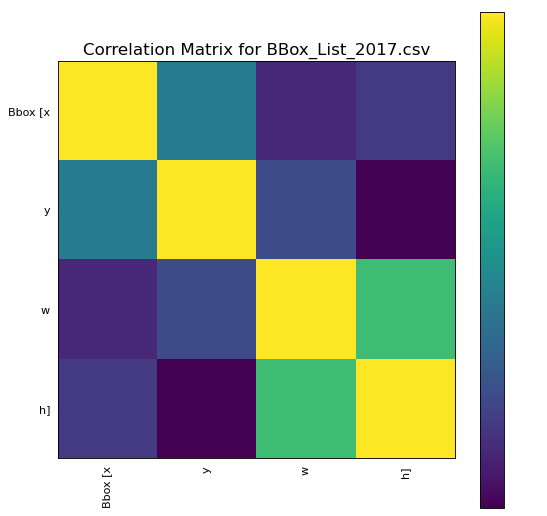

In [43]:
plotCorrelationMatrix(df1, 8)

/tmp/ipykernel_56257/102845399.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


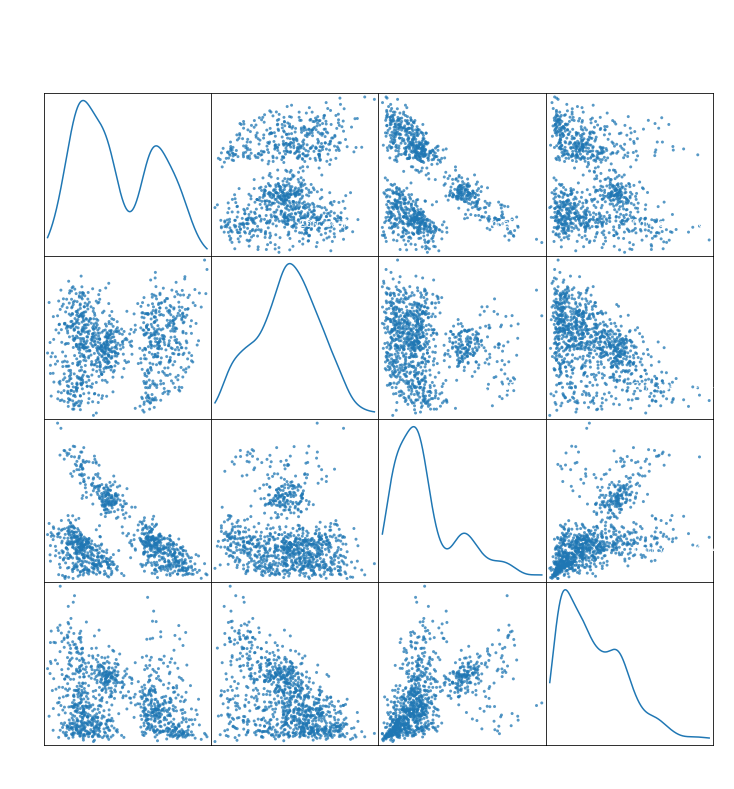

In [44]:
plotScatterMatrix(df1, 12, 10)

**Data_Entry_2017.csv**

In [45]:
nRowsRead = 1000 # specify 'None' to read whole file
df2 = pd.read_csv('/home/sachin/Documents/Projects/DSAI/chestxrayCV/data/Data_Entry_2017.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'Data_Entry_2017.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 12 columns


In [46]:
df2.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [47]:
plotPerColumnDistribution(df2, 10, 5)

ValueError: Number of rows must be a positive integer, not 1.6

<Figure size 2400x1024 with 0 Axes>

/tmp/ipykernel_56257/534742330.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


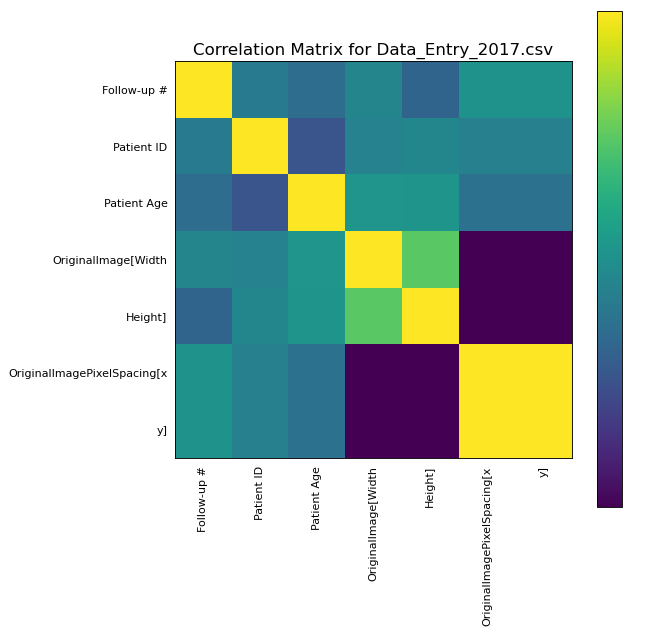

In [48]:
plotCorrelationMatrix(df2, 8)

/tmp/ipykernel_56257/102845399.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


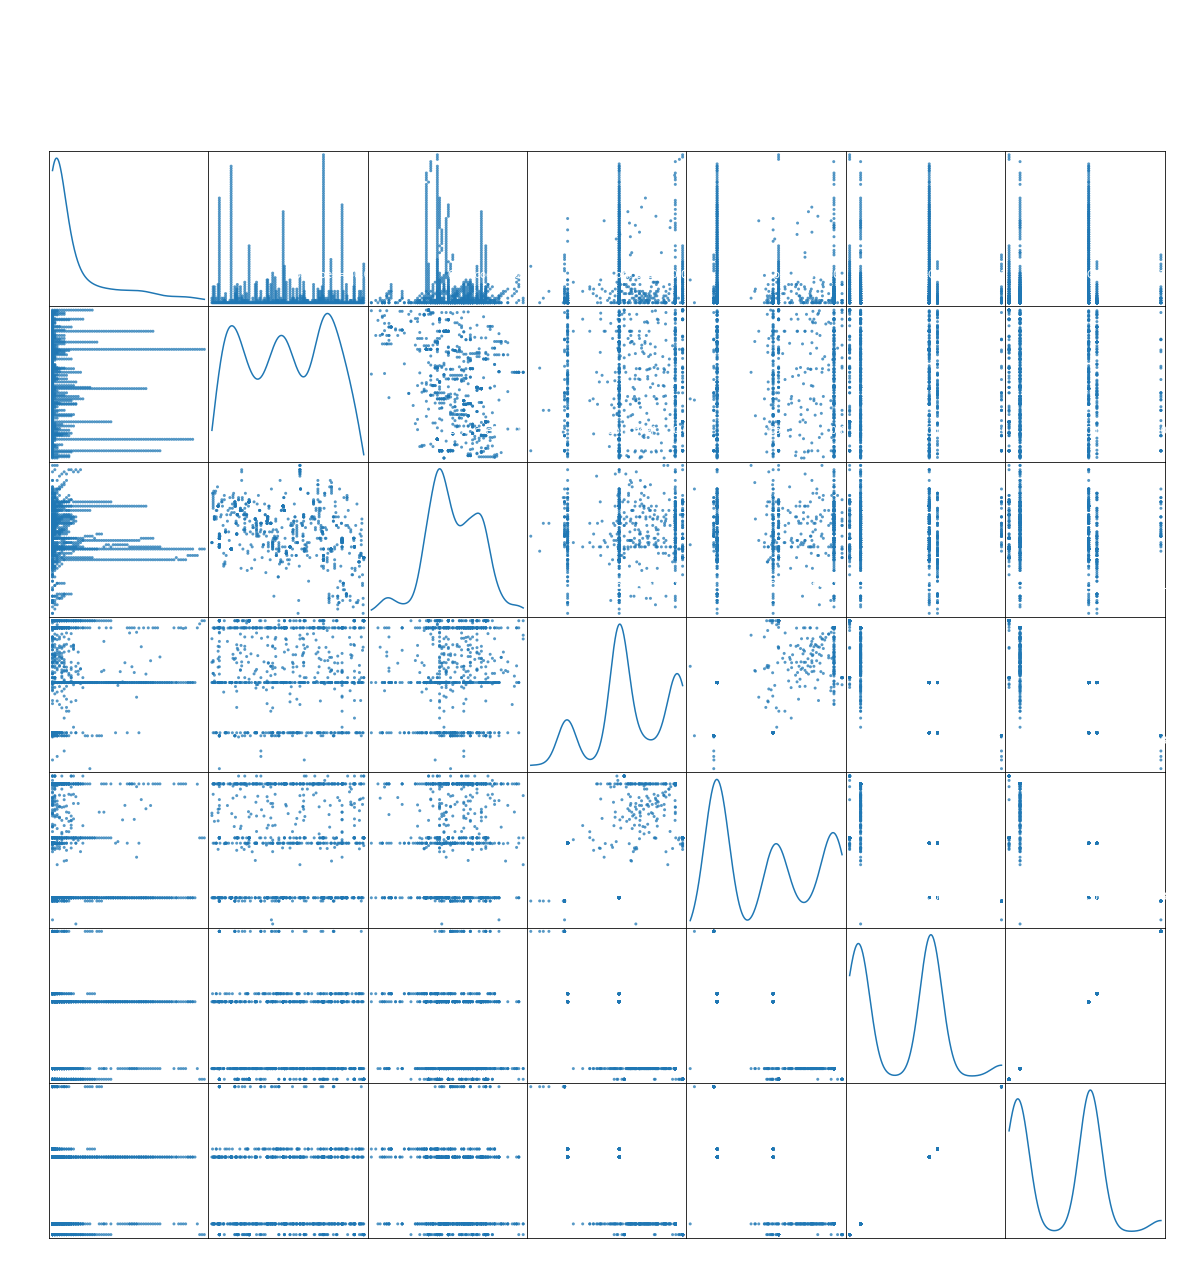

In [49]:
plotScatterMatrix(df2, 20, 10)